- One of the cleanest workflows ever; Also handles problem of data leaking gracefully....

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [11]:
# Load wine dataset from sklearn
wine_data = load_wine()
X = wine_data.data        # shape: (178, 13)
y = wine_data.target      # 3 classes: 0, 1, or 2

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22051662
)

# Scale/standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (142, 13)
Test set size: (36, 13)


In [12]:
class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)  # Convert to float32
        self.y = y.astype(np.int64)    # Class labels as int64 (required by PyTorch)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return a tuple of (features, label)
        features = self.X[idx]
        label = self.y[idx]
        return features, label

# Create Dataset instances
train_dataset = WineDataset(X_train, y_train)
test_dataset = WineDataset(X_test, y_test)

# Wrap with DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of train batches:", len(train_loader))
print("Number of test batches:", len(test_loader))


Number of train batches: 9
Number of test batches: 3


In [13]:
class WineNet(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=32, num_classes=3):
        super(WineNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

        # Optional: We'll include Dropout for regularization
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # x shape: (batch_size, 13)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)        # apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)           # raw logits
        return x

# Instantiate the model and move it to device
model = WineNet().to(device)
print(model)

WineNet(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

- i like to keep the train loop inside a function, so i can train indefinitely on the same model

In [15]:
train_losses = []
train_accuracies = []

In [16]:
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for features, labels in train_loader:
            # Move to device
            features, labels = features.to(device), labels.to(device)

            # 1) Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # 2) Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * features.size(0)

            # Calculate predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


In [17]:
train(10)

Epoch [1/10], Loss: 0.8925, Accuracy: 71.13%
Epoch [2/10], Loss: 0.3419, Accuracy: 94.37%
Epoch [3/10], Loss: 0.1157, Accuracy: 97.18%
Epoch [4/10], Loss: 0.0324, Accuracy: 98.59%
Epoch [5/10], Loss: 0.0534, Accuracy: 96.48%
Epoch [6/10], Loss: 0.0261, Accuracy: 99.30%
Epoch [7/10], Loss: 0.0044, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0277, Accuracy: 99.30%
Epoch [9/10], Loss: 0.0083, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0043, Accuracy: 100.00%


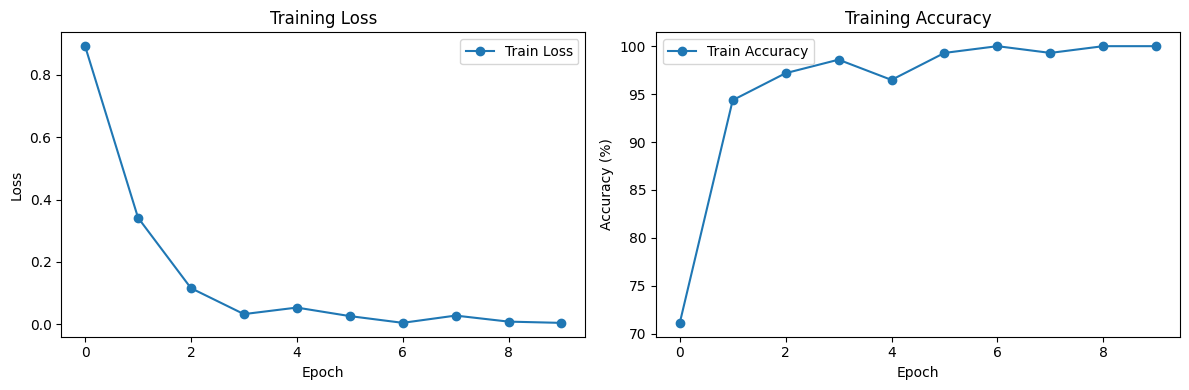

In [18]:
plt.figure(figsize=(12,4))

# Plot training loss
plt.subplot(1,2,1)
plt.plot(train_losses, '-o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, '-o', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()